## Setup

In [252]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import pandas as pd
import math
import seaborn as sns
import os
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import warnings
import lightning.pytorch as pl
import torch
import pickle
import matplotlib.cm as cm
import networkx as nx
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

np.random.seed(42)

In [2]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'

def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''

def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

In [42]:
def human_format2(num):
    for unit in ['', 'K', 'M', 'B']:
        if abs(num) < 1000:
            return f"{num:.0f}{unit}"
        num /= 1000
    return f"{num:.1f}T"

## Import data

In [3]:
online_retail_df = pd.read_json('../../dataset/online_retail_data/online_retail.json')
online_retail_df

,Description,Date,UnitsSold,RevenuePounds,AveragePricePerUnitPounds
0,12 pencils small tube red spotty,2009-12-01,45,29.90,0.66
1,12 pencils small tube red spotty,2009-12-02,87,61.75,0.71
2,12 pencils small tube red spotty,2009-12-03,34,23.40,0.69
3,12 pencils small tube red spotty,2009-12-04,84,55.25,0.66
4,12 pencils small tube red spotty,2009-12-05,0,0.00,0.65
...,...,...,...,...,...
73299,heart of wicker large,2010-12-05,94,261.30,2.78
73300,heart of wicker large,2010-12-06,34,118.06,3.47
73301,heart of wicker large,2010-12-07,462,1451.10,3.14
73302,heart of wicker large,2010-12-08,35,106.21,3.03


In [4]:
COMMON_DIR = '../../dataset/explanatory_variables'

uk_daily_cci = (
    pd.read_json(os.path.join(COMMON_DIR, 'cci.json'), typ='series')
    .rename_axis('date')
    .sort_index()
)
uk_daily_cpi = (
    pd.read_json(os.path.join(COMMON_DIR, 'cpi.json'), typ='series')
    .rename_axis('date')
    .sort_index()
)
uk_daily_interest_rate = (
    pd.read_json(os.path.join(COMMON_DIR, 'interest_rate.json'), typ='series')
    .rename_axis('date')
    .sort_index()
)
uk_public_holidays = (
    pd.read_json(os.path.join(COMMON_DIR, 'public_holidays.json'), typ='series')
    .rename_axis('date')
    .sort_index()
)
uk_daily_unemployment = (
    pd.read_json(os.path.join(COMMON_DIR, 'unemployment.json'), typ='series')
    .rename_axis('date')
    .sort_index()
)

## Analysis

### Retail data

In [7]:
summary_stats = online_retail_df.groupby('Description')['UnitsSold'].agg([
    'count', 'mean', 'std', 'min', 'max', lambda x: (x == 0).sum()
]).rename(columns={'<lambda_0>': 'zero_days'})
summary_stats.describe()

,count,mean,std,min,max,zero_days
count,196.0,196.000000,196.000000,196.0,196.000000,196.000000
mean,374.0,26.691245,54.389354,0.0,585.015306,128.530612
std,0.0,25.469463,49.459538,0.0,666.597533,31.357068
min,374.0,2.304813,3.589996,0.0,21.000000,68.000000
25%,374.0,11.763369,25.156335,0.0,222.000000,108.500000
50%,374.0,18.919786,39.245381,0.0,360.500000,127.000000
75%,374.0,34.524064,63.206401,0.0,701.750000,147.000000
max,374.0,160.804813,402.302425,0.0,5005.000000,193.000000


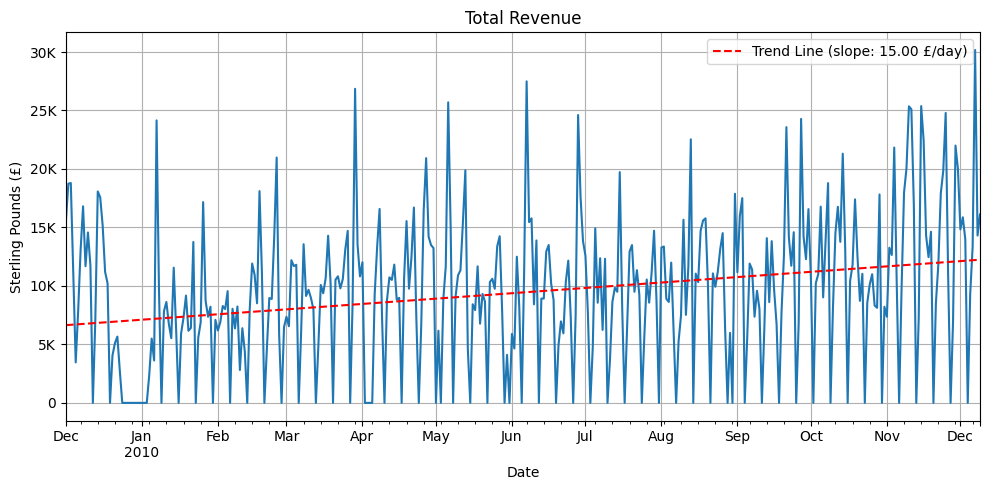

In [54]:
daily_revenue = online_retail_df.groupby('Date')['RevenuePounds'].sum().reset_index()
X = daily_revenue['Date'].map(lambda x: x.toordinal()).values.reshape(-1, 1)  # Convert dates to ordinal
y = daily_revenue['RevenuePounds'].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

slope = model.coef_[0]
slope_str = f"{slope:.2f}"

fig, ax = plt.subplots(figsize=(10,5))

online_retail_df.groupby('Date')['RevenuePounds'].sum().plot(ax=ax, label='')

ax.plot(data.index, y_pred, linestyle='--', color='red', label=f'Trend Line (slope: {slope_str} £/day)')

ax.set_title('Total Revenue')
ax.set_xlabel('Date')
ax.set_ylabel('Sterling Pounds (£)')
ax.grid(True)
ax.legend()
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

In [17]:
df = online_retail_df[['Date', 'UnitsSold', 'RevenuePounds']]

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df.loc[:,'DayOfWeek'] = df['Date'].dt.day_name()
df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=day_order, ordered=True)

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df.loc[:, 'Month'] = df['Date'].dt.month_name()

df.loc[:, 'Year'] = df['Date'].dt.year

def sort_year_month(series):
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    year_month_list = series.unique()
    # Parse each YearMonth string into (year, month_index) for sorting
    sortable_list = []
    for ym in year_month_list:
        year, month_name = ym.split('-')
        month_index = month_order.index(month_name)
        sortable_list.append((int(year), month_index, ym))
    sortable_list.sort()
    return [ym for year, month_index, ym in sortable_list]

df['YearMonth'] = df['Year'].astype(str) + '-' + df['Month']
ordered_year_months = sort_year_month(df['YearMonth'])
df['YearMonth_Ordered'] = pd.Categorical(df['YearMonth'], categories=ordered_year_months, ordered=True)

df

,Date,UnitsSold,RevenuePounds,DayOfWeek,Month,Year,YearMonth,YearMonth_Ordered
0,2009-12-01,45,29.90,Tuesday,December,2009,2009-December,2009-December
1,2009-12-02,87,61.75,Wednesday,December,2009,2009-December,2009-December
2,2009-12-03,34,23.40,Thursday,December,2009,2009-December,2009-December
3,2009-12-04,84,55.25,Friday,December,2009,2009-December,2009-December
4,2009-12-05,0,0.00,Saturday,December,2009,2009-December,2009-December
...,...,...,...,...,...,...,...,...
73299,2010-12-05,94,261.30,Sunday,December,2010,2010-December,2010-December
73300,2010-12-06,34,118.06,Monday,December,2010,2010-December,2010-December
73301,2010-12-07,462,1451.10,Tuesday,December,2010,2010-December,2010-December
73302,2010-12-08,35,106.21,Wednesday,December,2010,2010-December,2010-December


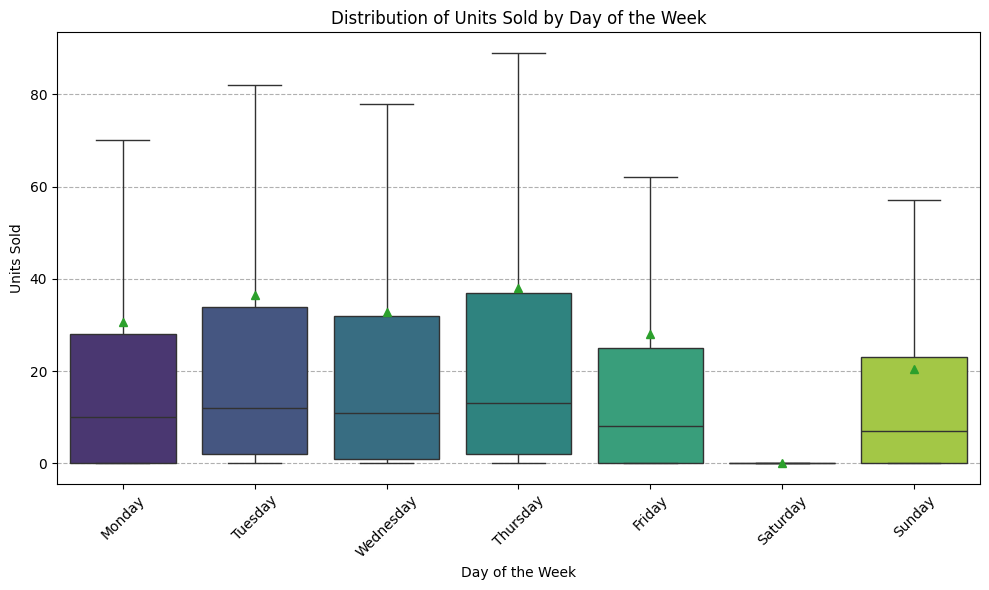

,count,mean,std,min,25%,50%,75%,max
DayOfWeek,,,,,,,,
Monday,10388.0,30.647382,84.155239,0.0,0.0,10.0,28.0,2654.0
Tuesday,10584.0,36.443689,96.558265,0.0,2.0,12.0,34.0,5005.0
Wednesday,10584.0,32.725435,77.407779,0.0,1.0,11.0,32.0,1684.0
Thursday,10584.0,38.043084,101.188624,0.0,2.0,13.0,37.0,4575.0
Friday,10388.0,27.949750,79.295981,0.0,0.0,8.0,25.0,2976.0
Saturday,10388.0,0.154890,2.505060,0.0,0.0,0.0,0.0,102.0
Sunday,10388.0,20.362437,45.449340,0.0,0.0,7.0,23.0,1230.0


In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='UnitsSold', data=df, order=day_order, palette='viridis', showfliers=False, showmeans=True)
plt.title('Distribution of Units Sold by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
df.groupby('DayOfWeek')['UnitsSold'].describe()

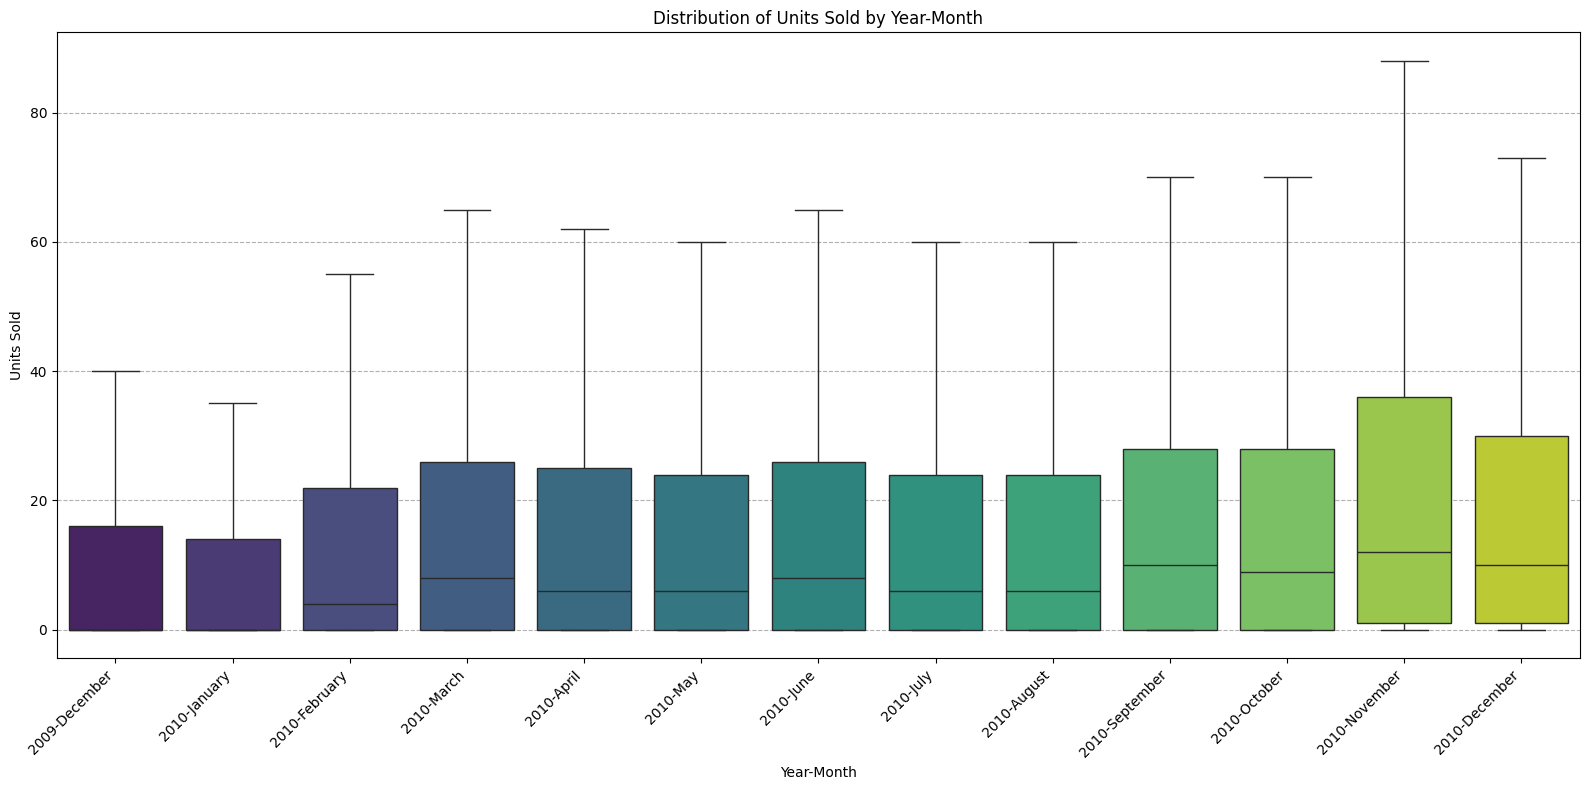

,count,mean,std,min,25%,50%,75%,max
YearMonth,,,,,,,,
2009-December,6076.0,20.291310,61.415745,0.0,0.0,0.0,16.0,1610.0
2010-April,5880.0,26.348469,63.988798,0.0,0.0,6.0,25.0,1200.0
2010-August,6076.0,27.057110,72.429239,0.0,0.0,6.0,24.0,2362.0
2010-December,1764.0,32.723356,114.892213,0.0,1.0,10.0,30.0,3264.0
2010-February,5488.0,22.697340,62.433656,0.0,0.0,4.0,22.0,1587.0
2010-January,6076.0,19.292298,59.806245,0.0,0.0,0.0,14.0,1193.0
2010-July,6076.0,23.196675,51.398740,0.0,0.0,6.0,24.0,759.0
2010-June,5880.0,29.287755,89.878477,0.0,0.0,8.0,26.0,2654.0
2010-March,6076.0,26.671001,63.454184,0.0,0.0,8.0,26.0,2016.0


In [19]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='YearMonth', y='UnitsSold', data=df, palette='viridis', showfliers=False)
plt.title('Distribution of Units Sold by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Units Sold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
df.groupby('YearMonth')['UnitsSold'].describe()

In [31]:
total_units_sold_by_product = online_retail_df.groupby('Description')['UnitsSold'].sum().sort_values(ascending=False)

p1 = total_units_sold_by_product.quantile(0.1)
p90 = total_units_sold_by_product.quantile(0.9)

bottom_products = total_units_sold_by_product[lambda x: x <= p1]
mid_products = total_units_sold_by_product[lambda x: (p1 < x) & (x < p90)]
top_products = total_units_sold_by_product[lambda x: x >= p90]

bottom_sample = list(np.random.choice(bottom_products.index, size=1))
mid_sample = list(np.random.choice(mid_products.index, size=2))
top_sample = list(np.random.choice(top_products.index, size=1))

product_sample = bottom_sample + mid_sample + top_sample
product_sample

['victorian sewing box large',
 'retro spot traditional teapot',
 'retro spot cake stand',
 'white hanging heart tlight holder']

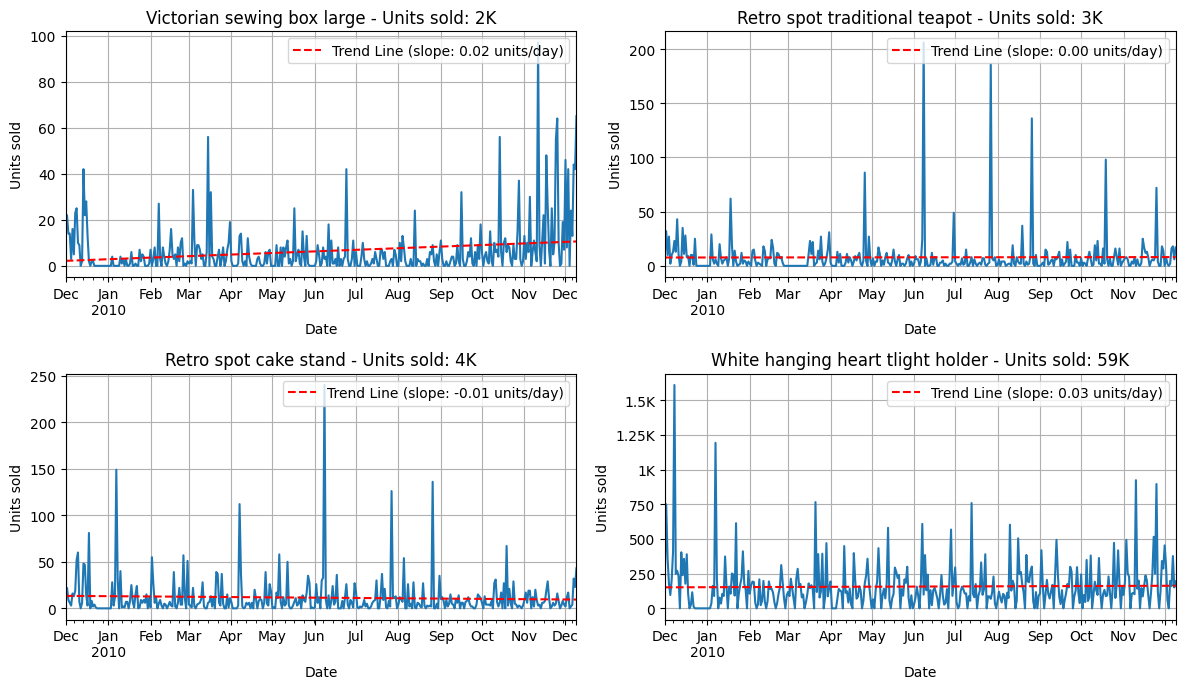

In [56]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

for ax, product in zip(axs.flatten(), product_sample):
    total_sold = total_units_sold_by_product.loc[product]
    data = online_retail_df.query(f'Description == "{product}"').set_index('Date')['UnitsSold'].sort_index()
    data.plot(ax=ax, label='')

    X = data.index.map(lambda x: x.toordinal()).values.reshape(-1, 1)
    y = data.values

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    slope = model.coef_[0]
    slope_str = f"{slope:.2f}"

    ax.plot(data.index, y_pred, linestyle='--', color='red', label=f'Trend Line (slope: {slope_str} units/day)')

    ax.set_title(f'{product.capitalize()} - Units sold: {human_format2(total_sold)}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Units sold')
    ax.grid()
    ax.legend(loc='upper right')
    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

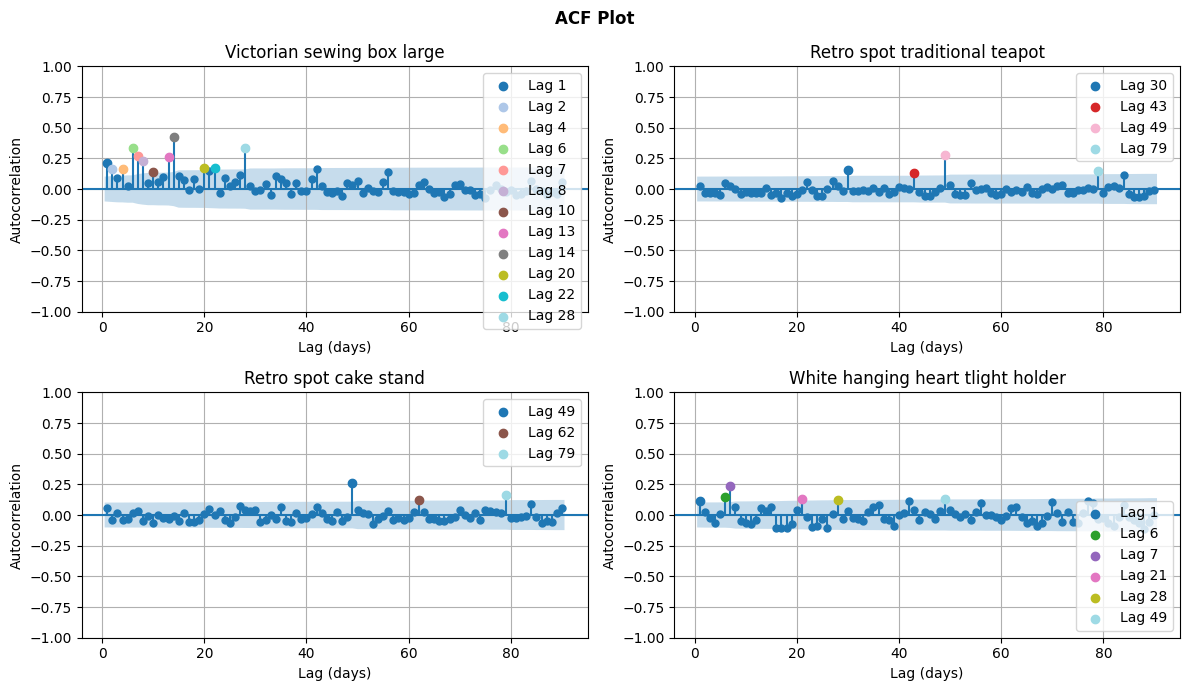

In [101]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

fig.suptitle('ACF Plot', fontweight='bold')

for ax, product in zip(axs.flatten(), product_sample):
    total_sold = total_units_sold_by_product.loc[product]
    data = online_retail_df.query(f'Description == "{product}"') \
                           .set_index('Date')['UnitsSold'] \
                           .sort_index()

    lags = 90

    plot_acf(data, lags=lags, ax=ax, zero=False)

    acf_vals, confints = acf(data, nlags=lags, alpha=0.05)
    significant_lags = [(lag, acf)
                        for lag, (acf, confint) in enumerate(zip(acf_vals[1:], confints[1:]), start=1)
                        if confint[0] > 0 or confint[1] < 0]

    colors = cm.get_cmap('tab20', len(significant_lags))
    for i, (lag, acf_val) in enumerate(significant_lags):
        ax.scatter(lag, acf_val, color=colors(i), label=f'Lag {lag}', zorder=5)

    ax.set_title(f'{product.capitalize()}')
    ax.set_xlabel('Lag (days)')
    ax.set_ylabel('Autocorrelation')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

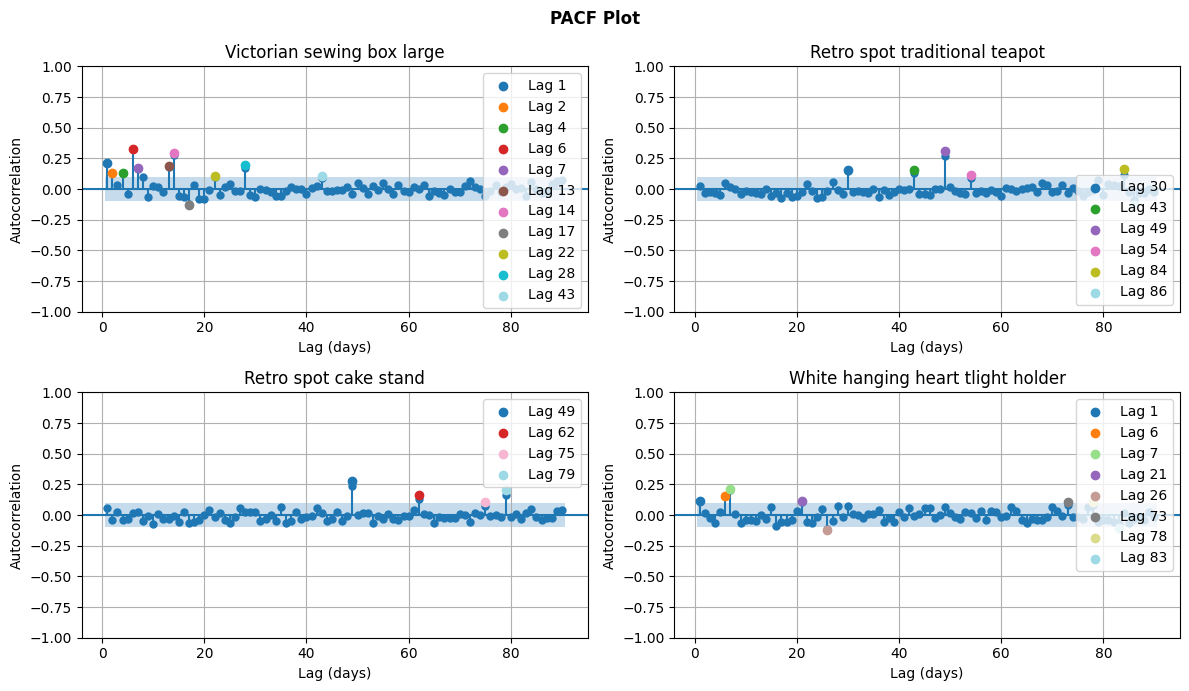

In [102]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

fig.suptitle('PACF Plot', fontweight='bold')

for ax, product in zip(axs.flatten(), product_sample):
    total_sold = total_units_sold_by_product.loc[product]
    data = online_retail_df.query(f'Description == "{product}"') \
                           .set_index('Date')['UnitsSold'] \
                           .sort_index()

    lags = 90

    plot_pacf(data, lags=lags, ax=ax, zero=False)

    pacf_vals, confints = pacf(data, nlags=lags, alpha=0.05)
    significant_lags = [(lag, pacf)
                        for lag, (pacf, confint) in enumerate(zip(pacf_vals[1:], confints[1:]), start=1)
                        if confint[0] > 0 or confint[1] < 0]

    colors = cm.get_cmap('tab20', len(significant_lags))
    for i, (lag, pacf_val) in enumerate(significant_lags):
        ax.scatter(lag, pacf_val, color=colors(i), label=f'Lag {lag}', zorder=5)

    ax.set_title(f'{product.capitalize()}')
    ax.set_xlabel('Lag (days)')
    ax.set_ylabel('Autocorrelation')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

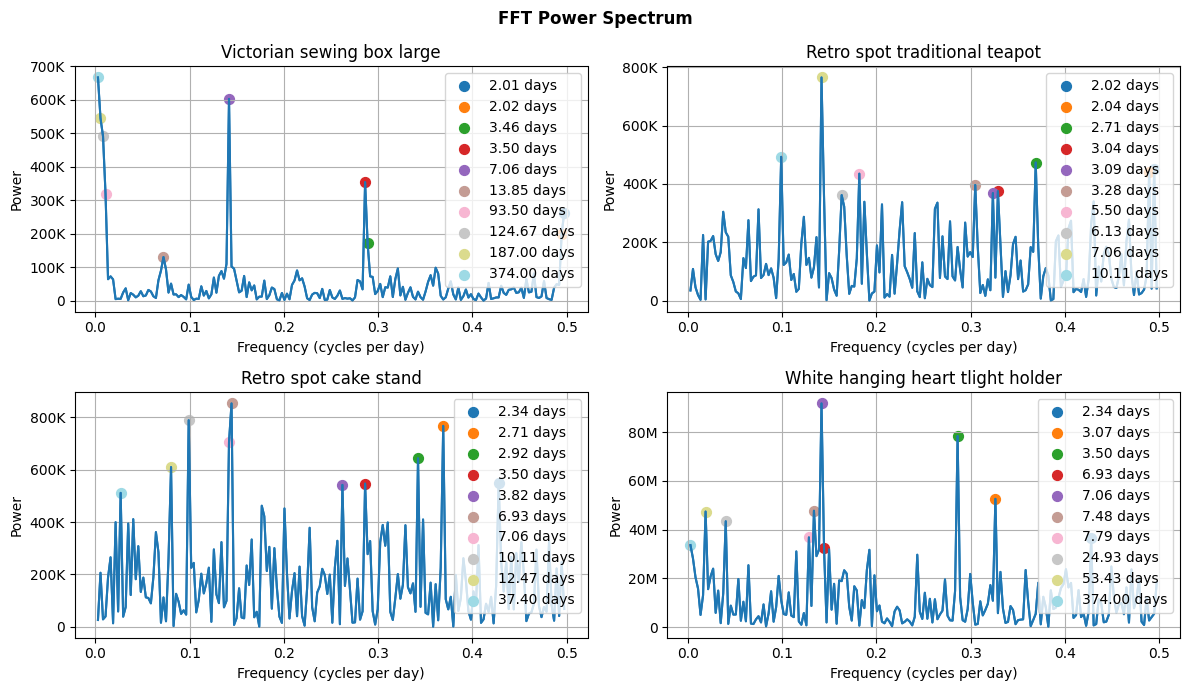

In [103]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

fig.suptitle('FFT Power Spectrum', fontweight='bold')

for ax, product in zip(axs.flatten(), product_sample):
    total_sold = total_units_sold_by_product.loc[product]
    data = online_retail_df.query(f'Description == "{product}"') \
                           .set_index('Date')['UnitsSold'] \
                           .sort_index()

    # Ensure daily frequency and fill missing dates
    data = data.asfreq('D').fillna(0)

    # Compute FFT and frequencies
    n = len(data)
    fft_vals = np.fft.fft(data - data.mean())
    freqs = np.fft.fftfreq(n, d=1)  # d=1 for daily frequency

    # Take positive frequencies only
    pos_mask = freqs > 0
    freqs = freqs[pos_mask]
    power = np.abs(fft_vals[pos_mask])**2

    # Plot power vs. frequency
    ax.plot(freqs, power, color='tab:blue')

    # Plot power spectrum
    ax.plot(freqs, power, color='tab:blue')

    # Identify top 5 peaks
    top_indices = np.argsort(power)[-10:]  # indices of top 5 powers
    top_freqs = freqs[top_indices]
    top_powers = power[top_indices]
    top_periods = 1 / top_freqs

    sorted_items = sorted(zip(top_freqs, top_powers, top_periods), key=lambda x: x[2])  # sort by period
    
    # Use consistent coloring
    colors = cm.get_cmap('tab20', len(top_periods))

    for i, (f, p, T) in enumerate(sorted_items):
        ax.scatter(f, p, color=colors(i), s=50, label=f'{T:.2f} days')

    ax.set_title(f'{product.capitalize()}')
    ax.set_xlabel('Frequency (cycles per day)')
    ax.set_ylabel('Power')
    ax.grid(True)
    ax.legend(loc='upper right')
    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

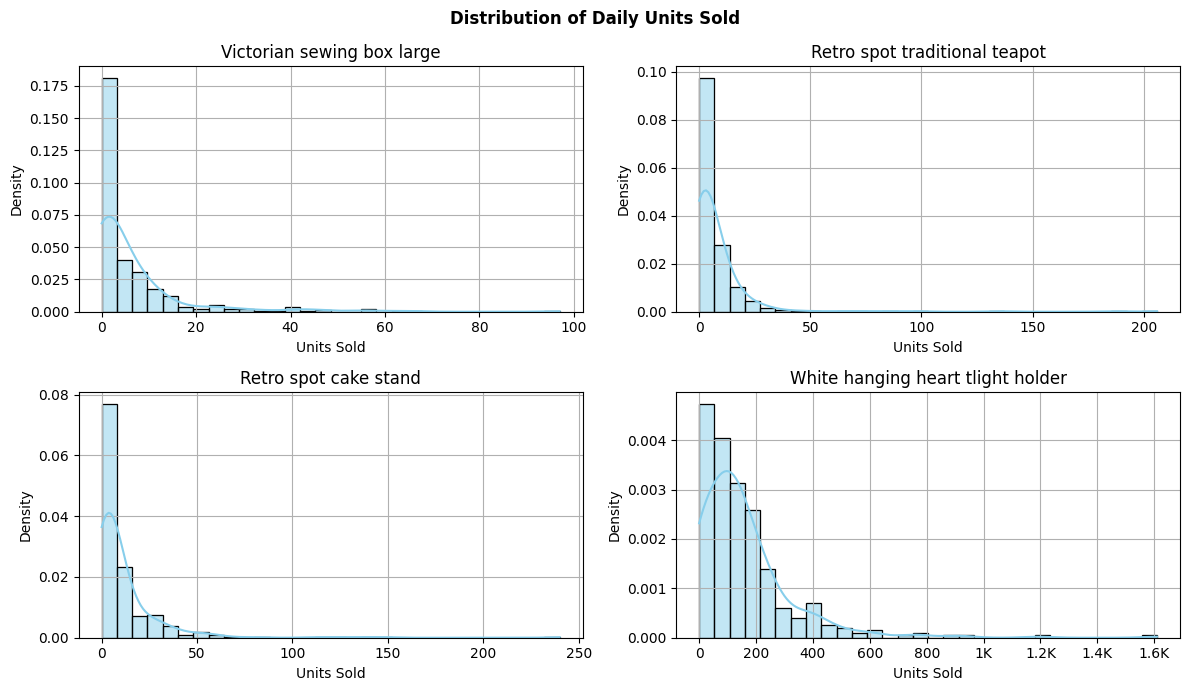

In [105]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

fig.suptitle('Distribution of Daily Units Sold', fontweight='bold')

for ax, product in zip(axs.flatten(), product_sample):
    total_sold = total_units_sold_by_product.loc[product]
    data = online_retail_df.query(f'Description == "{product}"')['UnitsSold']

    sns.histplot(data, kde=True, ax=ax, stat='density', bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'{product.capitalize()}')
    ax.set_xlabel('Units Sold')
    ax.set_ylabel('Density')
    ax.grid(True)
    make_axes_human_readable(ax, axis='x')

plt.tight_layout()
plt.show()

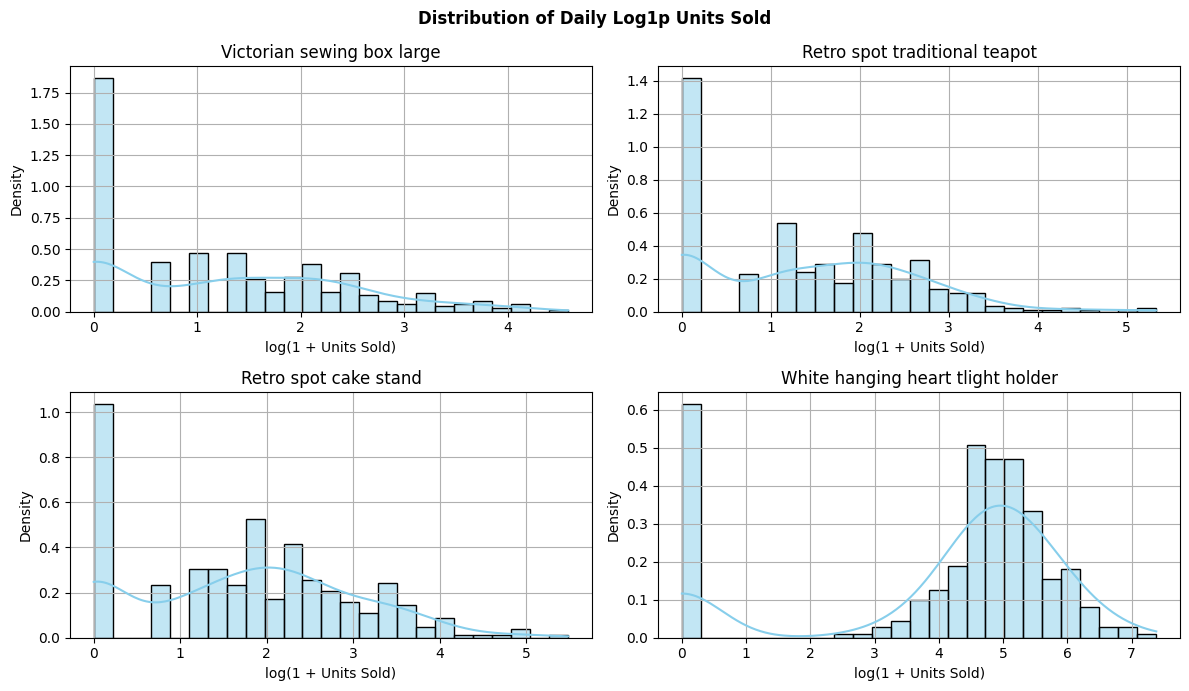

In [109]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

fig.suptitle('Distribution of Daily Log1p Units Sold', fontweight='bold')

for ax, product in zip(axs.flatten(), product_sample):
    total_sold = total_units_sold_by_product.loc[product]
    data = online_retail_df.query(f'Description == "{product}"')['UnitsSold']

    log_data = np.log1p(data)  # log(1 + x) transformation

    sns.histplot(log_data, kde=True, ax=ax, stat='density', bins=25, color='skyblue', edgecolor='black')
    ax.set_title(f'{product.capitalize()}')
    ax.set_xlabel('log(1 + Units Sold)')
    ax.set_ylabel('Density')
    ax.grid(True)

plt.tight_layout()
plt.show()

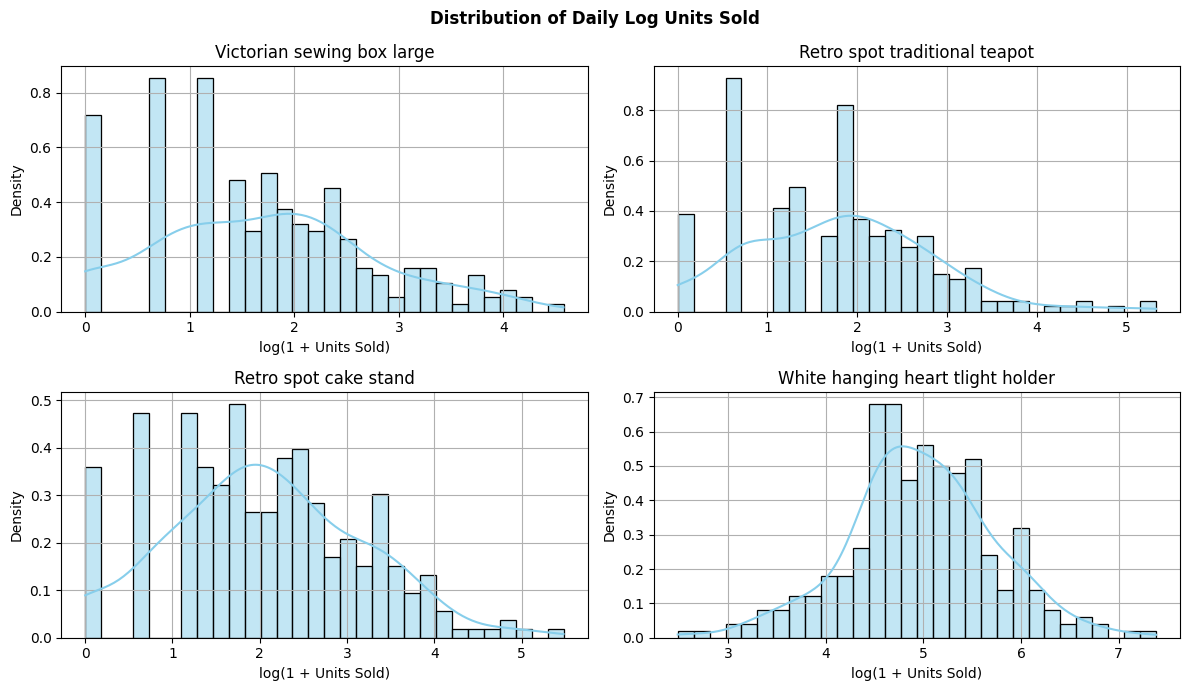

In [107]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

fig.suptitle('Distribution of Daily Log Units Sold', fontweight='bold')

for ax, product in zip(axs.flatten(), product_sample):
    total_sold = total_units_sold_by_product.loc[product]
    data = online_retail_df.query(f'Description == "{product}"')['UnitsSold']

    log_data = np.log(data[data > 0])

    sns.histplot(log_data, kde=True, ax=ax, stat='density', bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'{product.capitalize()}')
    ax.set_xlabel('log(1 + Units Sold)')
    ax.set_ylabel('Density')
    ax.grid(True)

plt.tight_layout()
plt.show()

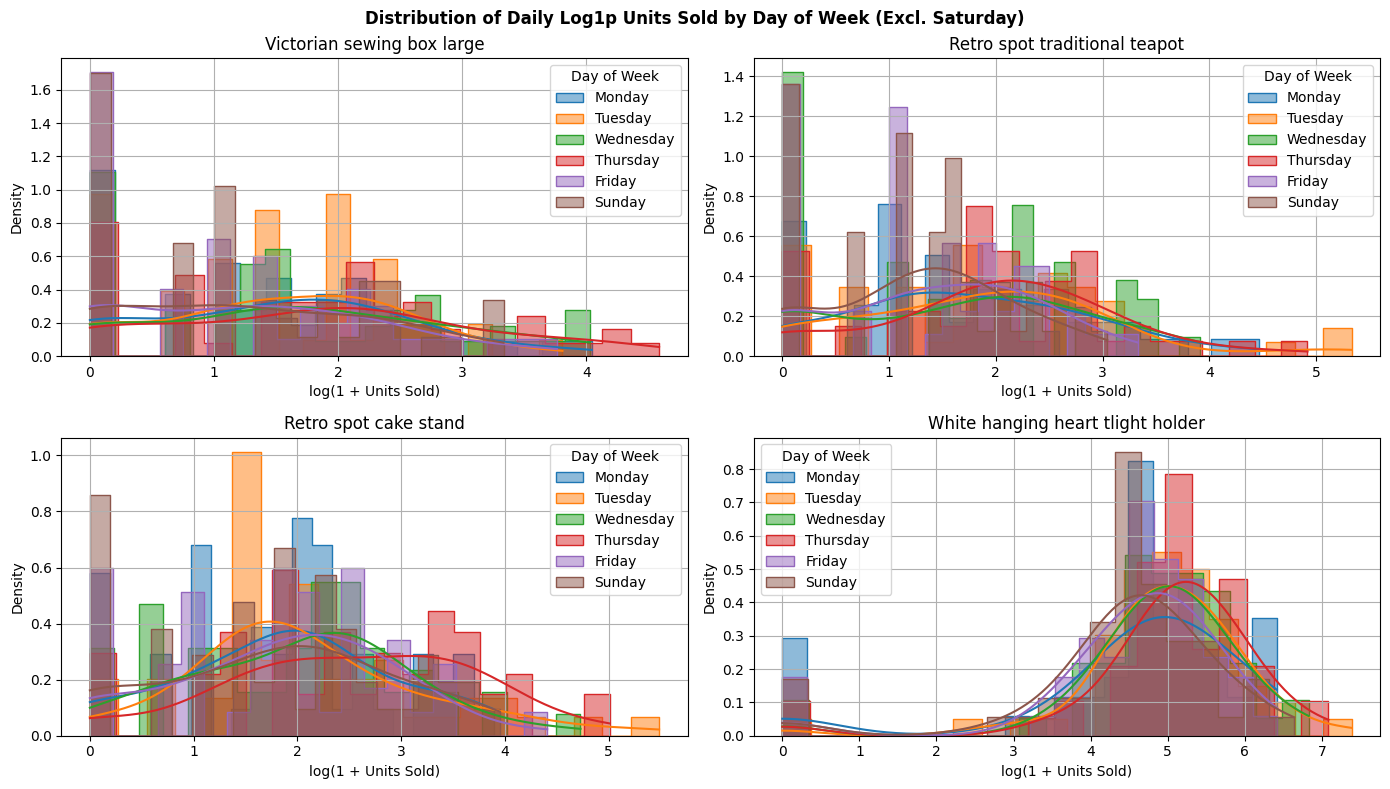

In [113]:
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']
palette = sns.color_palette('tab10', n_colors=len(ordered_days))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
fig.suptitle('Distribution of Daily Log1p Units Sold by Day of Week (Excl. Saturday)', fontweight='bold')

for ax, product in zip(axs.flatten(), product_sample):
    total_sold = total_units_sold_by_product.loc[product]

    product_df = online_retail_df.query(f'Description == "{product}"')[['Date', 'UnitsSold']].copy()
    product_df['DayOfWeek'] = product_df['Date'].dt.day_name()
    product_df['Log1pUnitsSold'] = np.log1p(product_df['UnitsSold'])

    for i, day in enumerate(ordered_days):
        day_data = product_df.query('DayOfWeek == @day')['Log1pUnitsSold']
        sns.histplot(
            day_data,
            kde=True,
            stat='density',
            bins=20,
            ax=ax,
            label=day,
            color=palette[i],
            element='step',
            fill=True,
        )

    ax.set_title(f'{product.capitalize()}')
    ax.set_xlabel('log(1 + Units Sold)')
    ax.set_ylabel('Density')
    ax.grid(True)
    ax.legend(title='Day of Week')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [121]:
top_sample_plus = top_products.sort_values().head(4).index.values
top_sample_plus

array(['pack of 60 dinosaur cake cases', 'hanging jam jar tlight holder',
       'jumbo bag strawberry', 'set10 pink spotty party candles'],
      dtype=object)

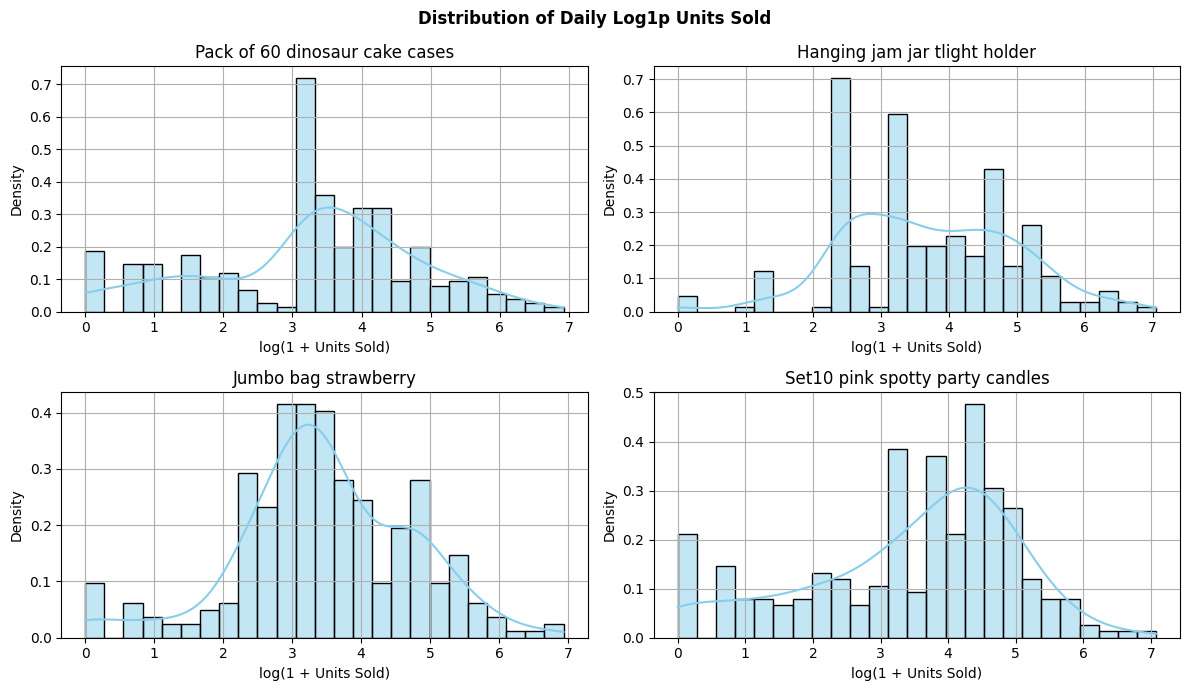

In [122]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

fig.suptitle('Distribution of Daily Log1p Units Sold', fontweight='bold')

for ax, product in zip(axs.flatten(), top_sample_plus):
    total_sold = total_units_sold_by_product.loc[product]
    data = online_retail_df.query(f'Description == "{product}"')['UnitsSold']

    log_data = np.log(data[data > 0])  # log(1 + x) transformation

    sns.histplot(log_data, kde=True, ax=ax, stat='density', bins=25, color='skyblue', edgecolor='black')
    ax.set_title(f'{product.capitalize()}')
    ax.set_xlabel('log(1 + Units Sold)')
    ax.set_ylabel('Density')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
units_sold_pivoted_df = (
    online_retail_df.pivot(
        index='Date', columns='Description', values='UnitsSold')
    .fillna(0)
)
units_sold_pivoted_df

Description,12 pencils small tube red spotty,12 pencils tall tube posy,12 pencils tall tube woodland,3 stripey mice feltcraft,6 ribbons rustic charm,60 teatime fairy cake cases,72 sweetheart fairy cake cases,airline bag vintage jet set red,antique silver tea glass etched,assorted colour bird ornament,...,wood black board ant white finish,wood s3 cabinet ant white finish,wooden box of dominoes,wooden frame antique white,wooden happy birthday garland,wooden picture frame white finish,wooden school colouring set,woodland charlotte bag,world war 2 gliders asstd designs,zinc metal heart decoration
Date,,,,,,,,,,,,,,,,,,,,,
2009-12-01,45,69,4,9,27,173,50,0,210,1272,...,0,5,18,38,0,30,0,34,48,66
2009-12-02,87,87,21,19,7,159,229,0,122,121,...,0,10,59,40,0,83,0,20,435,254
2009-12-03,34,116,13,101,3,201,83,0,158,312,...,0,26,58,46,21,48,0,10,56,104
2009-12-04,84,160,25,7,2,99,3,0,56,258,...,0,10,13,19,43,8,0,14,144,65
2009-12-05,0,24,0,0,0,0,0,0,12,24,...,0,26,0,48,0,54,0,0,48,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-05,151,6,15,4,49,9,19,8,148,129,...,49,3,20,30,13,39,17,42,96,34
2010-12-06,135,4,17,36,38,57,1,10,390,130,...,33,7,230,24,8,16,20,15,8,33
2010-12-07,20,15,9,9,37,30,28,8,162,271,...,1083,8,22,32,3,20,3,127,50,51


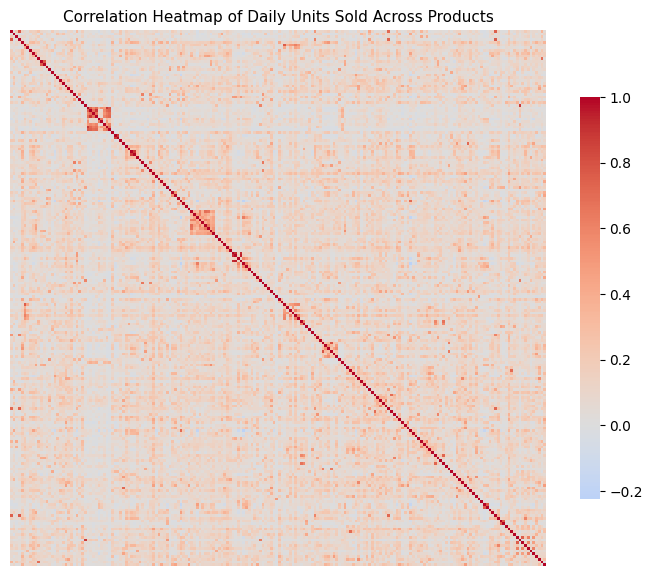

In [236]:
corr_matrix = units_sold_pivoted_df.corr()

plt.figure(figsize=(7, 7))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    square=True,
    cbar_kws={'shrink': 0.6},
    xticklabels=False,
    yticklabels=False
)
plt.xlabel('')
plt.ylabel('')
plt.title('Correlation Heatmap of Daily Units Sold Across Products', fontsize=11)
plt.tight_layout()
plt.show()

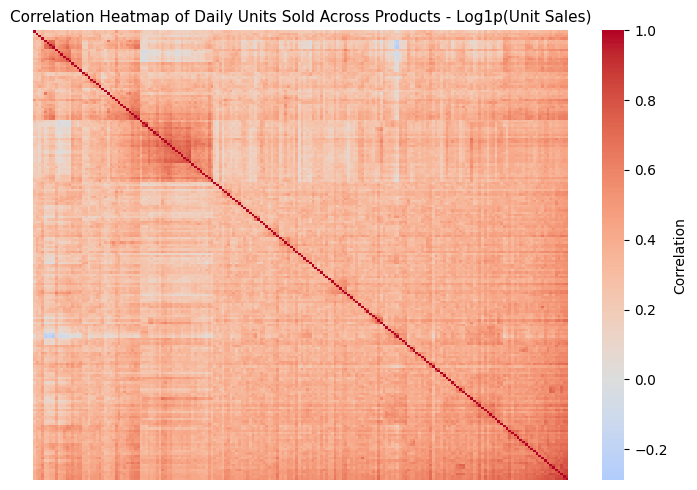

In [235]:
# Log transform to reduce skew
log_product_matrix = np.log1p(units_sold_pivoted_df)

# Correlation matrix
corr_matrix = log_product_matrix.corr()

# Hierarchical clustering to reorder rows/columns
linkage_matrix = linkage(squareform(1 - corr_matrix), method='average')
ordered_idx = leaves_list(linkage_matrix)
ordered_corr = corr_matrix.iloc[ordered_idx, ordered_idx]

# Clean heatmap without dendrogram
plt.figure(figsize=(7,5))
sns.heatmap(
    ordered_corr,
    cmap='coolwarm',
    center=0,
    xticklabels=False,
    yticklabels=False,
    cbar_kws={'label': 'Correlation'}
)
plt.title('Correlation Heatmap of Daily Units Sold Across Products - Log1p(Unit Sales)', fontsize=11)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [206]:
corr_matrix.index.name = "Product A"
corr_matrix.columns.name = "Product B"

# Mask lower triangle and diagonal
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Stack and filter
high_corr_pairs = upper.stack().reset_index()
high_corr_pairs.columns = ['Product A', 'Product B', 'Correlation']

# Filter for strong correlations
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.8]

# Sort by strength
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

# Show top results
high_corr_pairs


,Product A,Product B,Correlation
8943,hanging heart zinc tlight holder,white hanging heart tlight holder,0.928634
7634,feltcraft cushion owl,feltcraft cushion rabbit,0.858529
12426,love building block word,white hanging heart tlight holder,0.857227
15001,pack of 72 retro spot cake cases,white hanging heart tlight holder,0.854348
18631,strawberry ceramic trinket box,white hanging heart tlight holder,0.849205
1063,60 teatime fairy cake cases,pack of 72 retro spot cake cases,0.848308
8865,hanging heart zinc tlight holder,pack of 72 retro spot cake cases,0.847351
13115,lunchbag spaceboy design,lunchbag suki design,0.845887
14740,pack of 60 pink paisley cake cases,pack of 72 retro spot cake cases,0.843517
8840,hanging heart zinc tlight holder,love building block word,0.837287


In [207]:
# Create graph: nodes = products, edges = strong correlations
G = nx.Graph()

# Add edges from high_corr_pairs (already filtered to r > 0.8)
for _, row in high_corr_pairs.iterrows():
    G.add_edge(row['Product A'], row['Product B'], weight=row['Correlation'])

# Find connected components (clusters)
clusters = list(nx.connected_components(G))

# Print cluster sizes
for i, cluster in enumerate(clusters, 1):
    print(f"Cluster {i} ({len(cluster)} products): {sorted(cluster)}")

Cluster 1 (7 products): ['60 teatime fairy cake cases', 'hanging heart zinc tlight holder', 'love building block word', 'pack of 60 pink paisley cake cases', 'pack of 72 retro spot cake cases', 'strawberry ceramic trinket box', 'white hanging heart tlight holder']
Cluster 2 (2 products): ['feltcraft cushion owl', 'feltcraft cushion rabbit']
Cluster 3 (2 products): ['lunchbag spaceboy design', 'lunchbag suki design']
Cluster 4 (2 products): ['jumbo bag pink with white spots', 'lunchbag pink retrospot']
Cluster 5 (4 products): ['plasters in tin circus parade', 'plasters in tin spaceboy', 'plasters in tin strongman', 'plasters in tin woodland animals']
Cluster 6 (2 products): ['pack of 6 birdy gift tags', 'regency cakestand 3 tier']


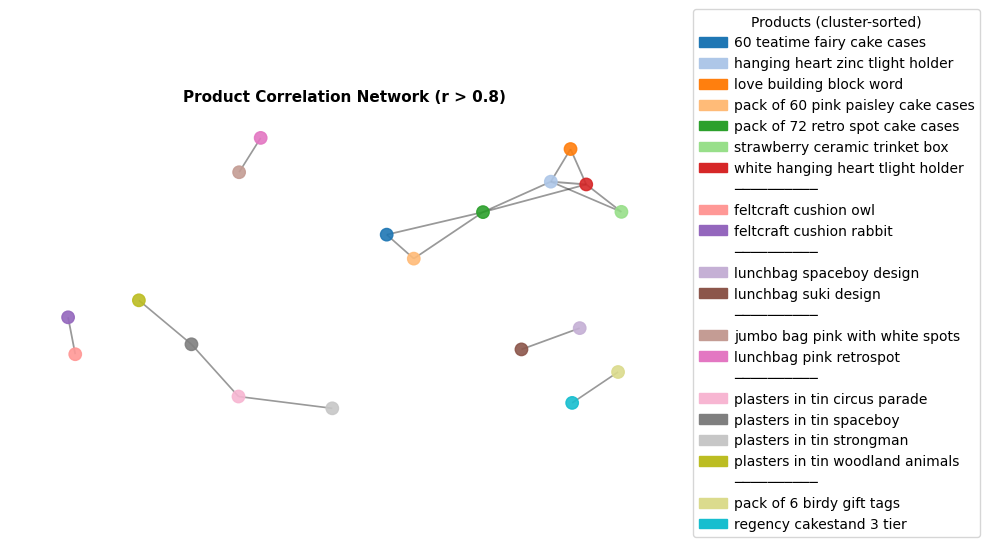

In [208]:
# Extract clusters
clusters = list(nx.connected_components(G))

# Flatten product list (product, cluster_id), sorted by cluster then name
clustered_products = []
for cluster_id, cluster in enumerate(clusters):
    for product in sorted(cluster):
        clustered_products.append((product, cluster_id))

# Limit to top N products
N = 20
top_products = clustered_products[:N]

# Assign distinct colors
tab20 = plt.get_cmap('tab20').colors
product_colors = {
    product: tab20[i % len(tab20)] for i, (product, _) in enumerate(top_products)
}
default_color = (0.8, 0.8, 0.8)

# Compute layout
pos = nx.spring_layout(G, k=0.5, seed=42)

# Draw graph
plt.figure(figsize=(10, 5))
node_colors = [product_colors.get(node, default_color) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=80, alpha=0.9)
nx.draw_networkx_edges(
    G, pos,
    edgelist=G.edges(),
    width=[G[u][v]['weight'] * 1.5 for u, v in G.edges()],
    alpha=0.4
)

# Build legend entries, adding separator between cluster transitions
legend_handles = []
last_cluster = None
for product, cluster_id in top_products:
    if last_cluster is not None and cluster_id != last_cluster:
        # Add a separator (a transparent patch with a line as the label)
        legend_handles.append(
            mpatches.Patch(color='none', label='──────────')  # separator line
        )
    legend_handles.append(
        mpatches.Patch(color=product_colors[product], label=product)
    )
    last_cluster = cluster_id

plt.legend(
    handles=legend_handles,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    title='Products (cluster-sorted)',
    handletextpad=0.5,
    borderaxespad=1
)

plt.title("Product Correlation Network (r > 0.8)", fontsize=11, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

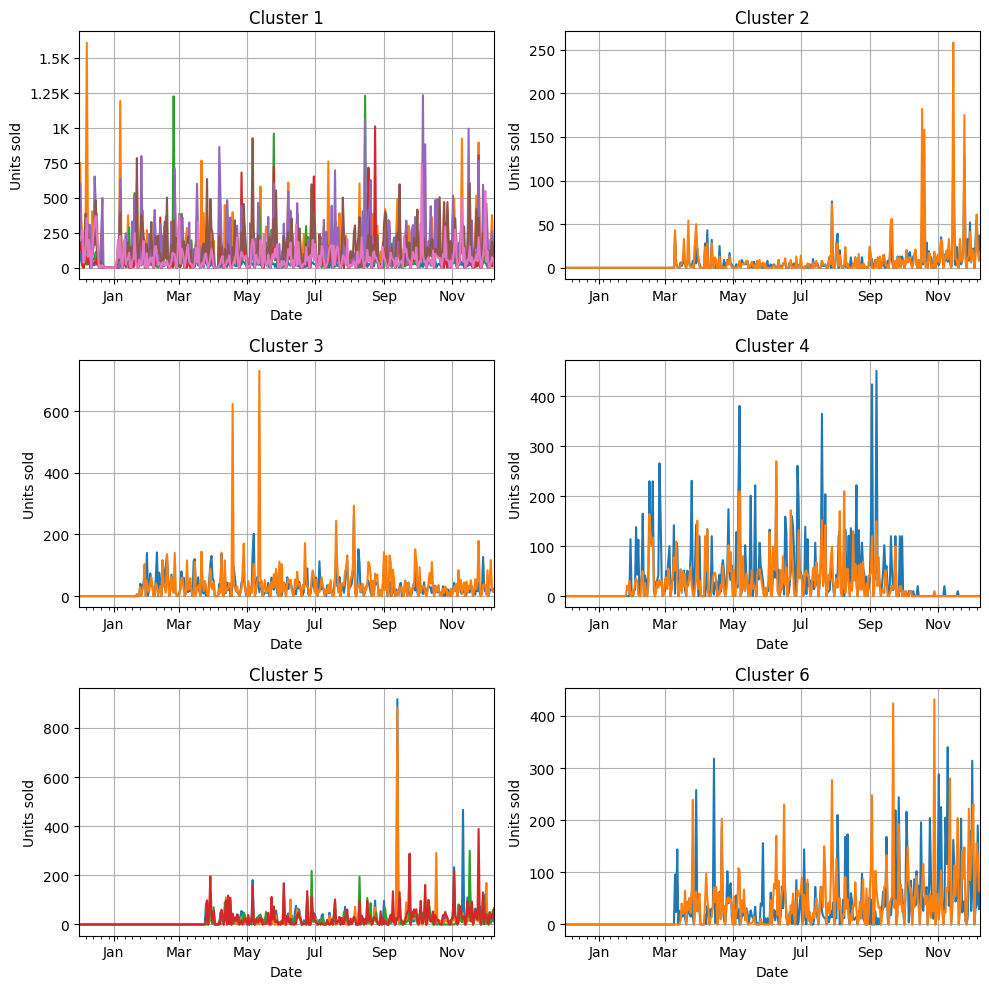

In [262]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

for i, (ax, cluster) in enumerate(zip(axs.flatten(), clusters), start=1):
    cluster = list(cluster)
    units_sold_pivoted_df[cluster].plot(ax=ax)

    ax.set_title(f'Cluster {i}')
    ax.set_xlabel("Date")
    ax.set_ylabel('Units sold')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # e.g., 'Jan 2010'
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # every 2 months
    ax.tick_params(axis='x', rotation=0)
    ax.legend().remove()
    ax.grid()
    make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

In [270]:
corr_matrix.index.name = "Product A"
corr_matrix.columns.name = "Product B"

# Mask lower triangle and diagonal
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Stack and filter
high_corr_pairs = upper.stack().reset_index()
high_corr_pairs.columns = ['Product A', 'Product B', 'Correlation']

# Filter for strong correlations
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.5]

# Sort by strength
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

# Create graph: nodes = products, edges = strong correlations
G = nx.Graph()

# Add edges from high_corr_pairs (already filtered to r > 0.8)
for _, row in high_corr_pairs.iterrows():
    G.add_edge(row['Product A'], row['Product B'], weight=row['Correlation'])

# Find connected components (clusters)
clusters = list(nx.connected_components(G))

# Print cluster sizes
for i, cluster in enumerate(clusters, 1):
    print(f"Cluster {i} ({len(cluster)} products): {sorted(cluster)}")

Cluster 1 (4 products): ['colour glass tlight holder hanging', 'lunch bag black skull', 'lunch bag cars blue', 'lunch bag woodland']
Cluster 2 (9 products): ['door mat 3 smiley cats', 'door mat fairy cake', 'door mat fancy font home sweet home', 'door mat new england', 'door mat red spot', 'door mat spotty home sweet home', 'door mat union flag', 'doormat hearts', 'doormat union jack guns and roses']
Cluster 3 (2 products): ['edwardian parasol black', 'edwardian parasol natural']
Cluster 4 (4 products): ['cream heart card holder', 'key fob shed', 'memo board retrospot design', 'wood black board ant white finish']
Cluster 5 (2 products): ['feltcraft cushion owl', 'feltcraft cushion rabbit']
Cluster 6 (3 products): ['plasters in tin circus parade', 'plasters in tin strongman', 'skulls water transfer tattoos']
Cluster 7 (5 products): ['12 pencils small tube red spotty', '3 stripey mice feltcraft', 'pink blue felt craft trinket box', 'retro spot tea set ceramic 11 pc', 'vintage heads and t

In [283]:
sales_matrix = (
    online_retail_df
    .pivot(index='Date', columns='Description', values='UnitsSold')
    .sort_index()
    .apply(np.log1p)  # log-transform to reduce skew
)

price_matrix = (
    online_retail_df
    .pivot(index='Date', columns='Description', values='AveragePricePerUnitPounds')
    .sort_index()
)

# Combine explanatory variables into one DataFrame
exog_df = pd.concat([
    uk_daily_cci.rename('CCI'),
    uk_daily_cpi.rename('CPI'),
    uk_daily_interest_rate.rename('InterestRate'),
    uk_daily_unemployment.rename('Unemployment'),
], axis=1)

In [292]:
lag_features = {}

for product in sales_matrix.columns:
    series = sales_matrix[product]
    df = pd.DataFrame({
        'Sales': series,
        'Lag_1': series.shift(1),
        'Lag_7': series.shift(7),
        'Roll_3': series.rolling(3).mean(),
        'Roll_7': series.rolling(7).mean()
    })

    df = df.join(pd.concat([
        uk_daily_cci.rename('CCI'),
        uk_daily_cpi.rename('CPI'),
        uk_daily_interest_rate.rename('InterestRate'),
        uk_daily_unemployment.rename('Unemployment'),
        online_retail_df[online_retail_df['Description'] == product]
            .set_index('Date')['AveragePricePerUnitPounds']
            .rename('Price')
    ], axis=1), how='left')

    df = df.dropna()

    if not df.empty:
        lag_features[product] = df.corr().loc[
            ['CCI', 'CPI', 'InterestRate', 'Unemployment', 'Price', 'Lag_1', 'Lag_7', 'Roll_3', 'Roll_7'],
            'Sales'
        ]

correlation_df = pd.DataFrame.from_dict(lag_features, orient='index')
correlation_df

,CCI,CPI,InterestRate,Unemployment,Price,Lag_1,Lag_7,Roll_3,Roll_7
12 pencils small tube red spotty,-0.348058,0.323915,0.368086,0.056509,-0.207302,0.248242,0.440986,0.671803,0.525590
12 pencils tall tube posy,-0.003830,0.039412,0.018844,0.042731,-0.035056,0.041969,0.284735,0.613151,0.403890
12 pencils tall tube woodland,-0.269584,0.270213,0.288071,0.058256,-0.151520,0.081773,0.372626,0.627913,0.449709
3 stripey mice feltcraft,-0.178829,0.210095,0.225856,0.117226,-0.113474,0.105822,0.259787,0.634880,0.450137
6 ribbons rustic charm,-0.550446,0.545574,0.559465,-0.051252,-0.428478,0.482620,0.672090,0.773011,0.690191
...,...,...,...,...,...,...,...,...,...
wooden picture frame white finish,-0.410783,0.378825,0.302269,-0.296136,-0.214481,0.420383,0.556523,0.761282,0.640685
wooden school colouring set,-0.448659,0.433495,0.475015,-0.048479,0.084587,0.404265,0.547777,0.757014,0.646385
woodland charlotte bag,-0.150299,0.158157,0.150571,0.032208,-0.152019,0.088429,0.410462,0.603631,0.414062
world war 2 gliders asstd designs,-0.167391,0.165309,0.185052,0.073423,0.026574,0.127324,0.260531,0.599890,0.413127


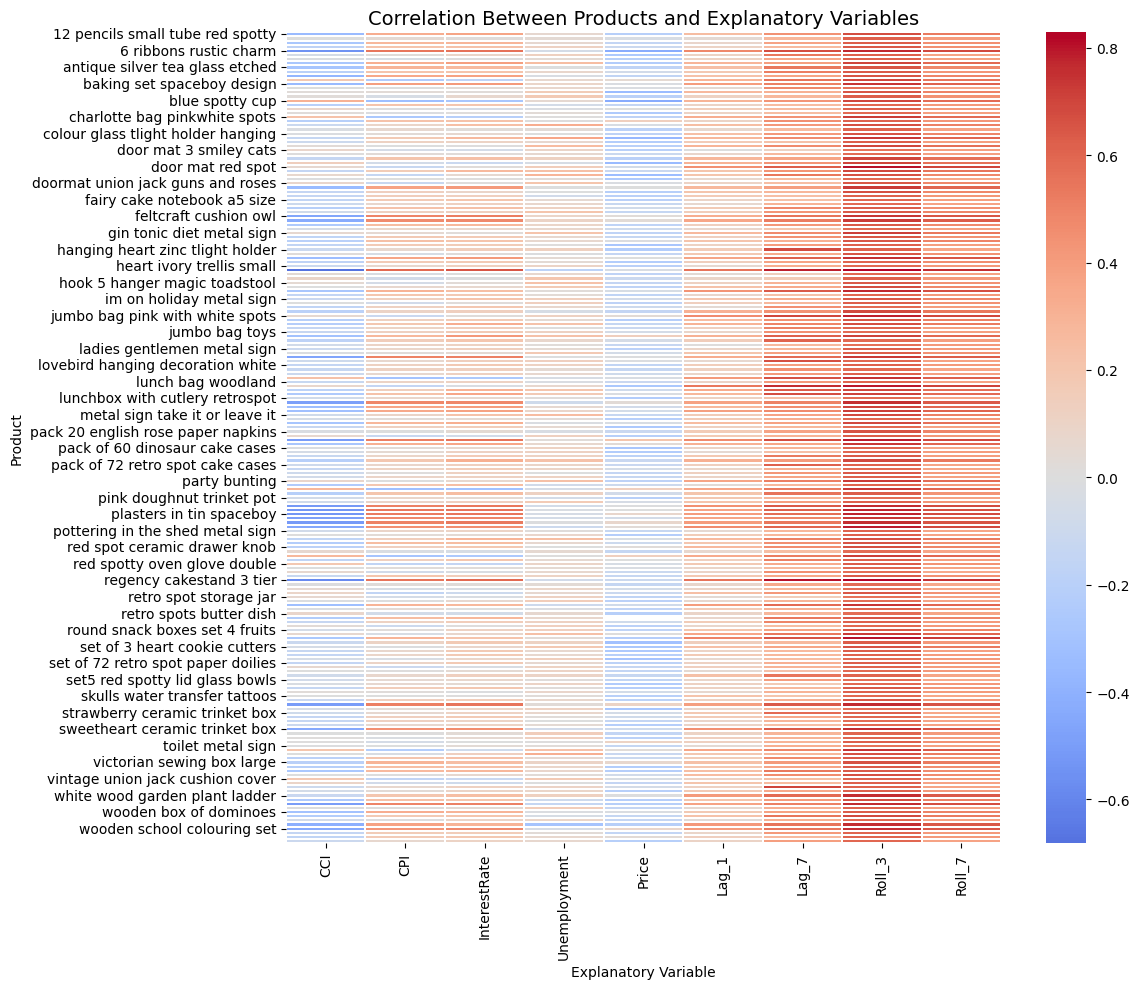

In [293]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df, cmap='coolwarm', center=0, linewidths=0.1)

plt.title("Correlation Between Products and Explanatory Variables", fontsize=14)
plt.xlabel("Explanatory Variable")
plt.ylabel("Product")
plt.tight_layout()
plt.show()